# Thermal Expansivity and Heat Capacity of Neutral Planar Lipid Bilayers
This notebook guides you through a protocol to simulate and analyze planar lipid bilayers of a highly coarse-grained lipid model.<br> 
Simulations are performed using the Monte Carlo code [Faunus](http://mlund.github.io/faunus/).<br>
The focus of the first section is to calculate the thermal expansivity and the heat capacity at various temperatures.<br>
To begin with, we reproduce some results published by [Cooke and Deserno](https://aip.scitation.org/doi/10.1063/1.2135785) for the Cooke 3-bead lipid model.<br> 
Then, we increase the range of the attraction between the tail beads. Will the gel-fluid phase transition occur at a different temperature? Will the thermal expansivity of the fluid phase increase or decrease?<br>

#### Table of contents
1. [Running the Simulations](#1)
2. [Density Profiles](#2)
3. [Analysis of the System Energy](#3)
4. [Analysis of the Area per Lipid](#4)

Let's import all the packages that you'll need to generate the input files and analyze the output. 
- [numpy](www.numpy.org) is a package to store and manipulate numerical arrays.
- [matplotlib](http://matplotlib.org) is the plotting library.
- [jinja2](http://jinja.pocoo.org/docs/2.10) is used here to fill out the template of the Faunus input.

In [53]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from jinja2 import Template
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir

/lunarc/nobackup/users/gtesei00/hexcyl


Let's initialize some parameters.

In [130]:
R = 8.3145 # gas constant in J/K/mol
eps = R*298 / 1.1 / 1000 # energy parameter in kJ/mol
sigma = 8 # length parameter in Å
print("eps:",eps,"kJ/mol")

eps: 2.252473636363636 kJ/mol


In [131]:
Ts = np.arange(253,321,5) # range of temperatures to explore
Ts

array([253, 258, 263, 268, 273, 278, 283, 288, 293, 298, 303, 308, 313,
       318])

<a id='1'></a>

## Running the Simulations

Our simulation protocol is divided into two steps:
- a short simulation in a cuboid cell of constant dimensions to confine the lipids in the $xy$-plane;
- a long simulation without confinement potential in a cuboid cell of varying aspect ratio, $L_z$/$L_x$=$L_z$/$L_y$, and constant volume, $V=L_x L_y L_z$.<br>
In the long simulation, we monitor $L_x$, system energy, and density profiles along $z$.<br>

In [139]:
template = Template("""comment: "3-bead Cooke lipid model. More information: doi:10/chqzjk"
temperature: {{T}}
random: {seed: hardware}
geometry: {type: cuboid, length: [{{L}}, {{L}}, {{2.5*L}}]}
mcloop: {macro: 10, micro: {{micro}}}

atomlist:
    - TL: {sigma: {{sigma}}, eps: {{eps}}, dp: 2}
    - HD: {sigma: {{sigma*0.95}}, eps: {{eps}}, dp: 2}

moleculelist:
    - lipid:
        structure:
            - HD: [0,0,0]
            - TL: [0,0,{{sigma}}]
            - TL: [0,0,{{2*sigma}}]
        bondlist:
            - fene+wca: {index: [0,1], k: {{30*eps/sigma/sigma}}, rmax: {{1.5*sigma}}, 
                sigma: {{sigma}}, eps: {{eps}}}
            - fene+wca: {index: [1,2], k: {{30*eps/sigma/sigma}}, rmax: {{1.5*sigma}}, 
                sigma: {{sigma}}, eps: {{eps}}}
            - harmonic: {index: [0,2], k: {{10*eps/sigma/sigma}}, req: {{4*sigma}}}

insertmolecules:
    - lipid: {N: 150}

energy:
    - confine: {type: cuboid, low: [-1e5,-1e5,-30], 
                 high: [1e5,1e5,30], k: {{k}},
                 molecules: [lipid], com: True}
    - bonded: {}
    - nonbonded_cached:
        cutoff_g2g: 50
        default:
            - wca: {mixing: LB}
        TL TL:
            - wca:
                mixing: LB
                custom:
                    TL TL: {sigma: {{sigma}}, eps: {{eps}}}
            - cos2: {rc: {{1.122462*sigma}}, eps: {{eps}}, wc: {{wc*sigma}}}
        HD TL:
            - wca:
                mixing: LB
                custom:
                    HD TL: {sigma: {{sigma}}, eps: {{eps}}}
        HD HD:
            - wca:
                mixing: LB
                custom:
                    HD HD: {sigma: {{sigma*0.95}}, eps: {{eps}}}

moves:
    - moltransrot: {molecule: lipid, dp: 1.0, dprot: 0.5, repeat: 150}
    - transrot: {molecule: lipid, repeat: 150}
    - volume: {dV: 0.04, method: isochoric, repeat: {{repeat}}}
        
analysis:
    - savestate: {file: state{{T}}.json}
    - savestate: {file: confout{{T}}.pqr}
    - savestate: {file: confout{{T}}.gro}
    - systemenergy: {file: energy{{T}}.dat, nstep: 1e2}
    - xtcfile: {file: traj{{T}}.xtc, nstep: 1e5}
    - reactioncoordinate: {file: Lx{{T}}.dat, nstep: 1e2, type: system, property: Lx}
    - sliceddensity: {file: HD{{T}}.dat, nstep: 1e2, atoms: [HD], dz: 0.5, nskip: 2e5, atomcom: TL}
    - sliceddensity: {file: TL{{T}}.dat, nstep: 1e2, atoms: [TL], dz: 0.5, nskip: 2e5, atomcom: TL}
    - sanity: {nstep: 1e4}""")

In [140]:
submit = Template("""#!/bin/bash
#requesting the number of cores needed on exclusive nodes
#SBATCH -p snic
#SBATCH -N 1
#SBATCH --ntasks-per-node=1
#SBATCH -A snic2019-3-188
#
# job time, change for what your job requires
#SBATCH -t 10:0:0
#
# job name
#SBATCH -J {{T}}
#
# filenames stdout and stderr
#SBATCH -o out_{{T}}
#SBATCH -e err_{{T}}

module load GCC/8.2.0-2.31.1
module load OpenMPI/3.1.3

../../faunus/faunus --input ine{{T}}.json --output oute{{T}}.json --nobar
../../faunus/faunus --input inp{{T}}.json --state state{{T}}.json --output outp{{T}}.json --nobar
""")

In [165]:
%cd $workdir/3bead
%mkdir 1.6
%cd 1.6

/lunarc/nobackup/users/gtesei00/hexcyl/3bead
mkdir: cannot create directory ‘1.6’: File exists
/lunarc/nobackup/users/gtesei00/hexcyl/3bead/1.6


In [142]:
for T in Ts:
    with open('ine{:d}.yml'.format(T), 'w') as input_file:
        # use jinja2 to specify the variable in the template (confine on, volume moves off, short simulation)
        input_file.write(template.render(T=T, wc=1.6, L=75, micro=2e3, sigma=sigma, eps=eps, k=10, repeat=0))
    !../../faunus/scripts/yason.py ine{T}.yml > ine{T}.json
    with open('inp{:d}.yml'.format(T), 'w') as input_file:
        # use jinja2 to specify the variable in the template (confine off, volume moves on, long simulation)
        input_file.write(template.render(T=T, wc=1.6, L=75, micro=1e5, sigma=sigma, eps=eps, k=0, repeat=1))
    !../../faunus/scripts/yason.py inp{T}.yml > inp{T}.json
    with open('submit{:d}.sh'.format(T), 'w') as submit_file:
        temp = submit.render(T=T)
        submit_file.write(temp)  
    !sbatch submit{T}.sh

Submitted batch job 2715437
Submitted batch job 2715438
Submitted batch job 2715439
Submitted batch job 2715440
Submitted batch job 2715441
Submitted batch job 2715442
Submitted batch job 2715443
Submitted batch job 2715444
Submitted batch job 2715445
Submitted batch job 2715446
Submitted batch job 2715447
Submitted batch job 2715448
Submitted batch job 2715449
Submitted batch job 2715450


<a id='2'></a>

## Density Profiles
Plot the density profiles along the $z$-coordinate calculated at runtime in the simulations at various temperatures. 
- Are the density profiles consistent with bilayer structures? 
- How do they change with increasing temperature?

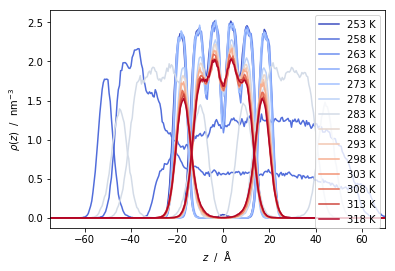

In [162]:
cm = plt.cm.coolwarm(np.linspace(0, 1, Ts.size))
for i,T in enumerate(Ts):
    x,y = np.loadtxt('HD{:d}.dat'.format(T),unpack=True)
    plt.plot(x,y*6.022/10,color=cm[i])
    x,y = np.loadtxt('TL{:d}.dat'.format(T),unpack=True)
    plt.plot(x,y*6.022/10,color=cm[i],label='{:d} K'.format(T))
plt.xlim(-75,70)
plt.legend()
plt.xlabel('$z$  /  Å')
plt.ylabel(r'$\rho(z)$  /  nm$^{-3}$')

<a id='3'></a>

## Analysis of the System Energy

### System Energy vs MC Sweeps
- How many MC sweeps, $N_{eq}$, are needed to reach a plateau in the system energy, $U$? 
- Does $N_{eq}$ depend on temperature? 

In [145]:
Neq = 1000

StopIteration: 

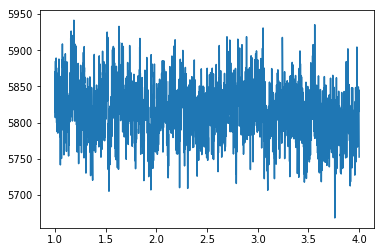

In [161]:
for T in Ts:
    x,y,_,__,___ = np.loadtxt('energy{:d}.dat'.format(T),unpack=True,skiprows=Neq)
    plt.plot(x/1e5,y)
plt.ylabel('$U$  /  $k_B T$')
plt.xlabel('10$^5$ MC Sweeps')

### Heat Capacity vs Temperature
Set the appropriate $N_{eq}$ and calculate the heat capacity at equilibrium for each temperature.<br>
In the canonical ensemble ($N$, $V$, $T$ given and fixed), the heat capacity can be estimated from the fluctuations in system energy, 
$$
C_V = \frac{\langle U^2 \rangle - \langle U \rangle^2}{R T^2}.
$$
- Is there a trend in $C_V$ vs $T$? 
- At what $T$ can we identify a phase transition? 
- How does this $T$ compare with the results reported by Cooke and Deserno?

In [163]:
Neq = 1000

In [166]:
cv = np.empty(0)
for T in Ts[4:]:
    x,y,_,__,___ = np.loadtxt('energy{:d}.dat'.format(T),unpack=True,skiprows=Neq)
    cv = np.append(cv, R * ( (y**2).mean() - y.mean()**2 ) / 1000 )
plt.plot(Ts[4:],cv,lw=.5, marker='o', ms=10,label='{:d}'.format(T) )
plt.ylabel('$C_V$  /  kJ K$^{-1}$ mol$^{-1}$')
plt.xlabel('$T$  /  K')

StopIteration: 

<a id='4'></a>

## Analysis of the Area per Lipid

### $L_x$ vs MC Sweeps
- How many MC sweeps, $N_{eq}$, are needed to reach equilibrium? 
- Does $N_{eq}$ depend on temperature? 
- Do you estimate the same $N_{eq}$ from $U$ and $L_x$?
- Is there a trend in the box length $L_x$ with increasing $T$?

In [86]:
Neq = 1000

Text(0.5,0,'10$^5$ MC Sweeps')

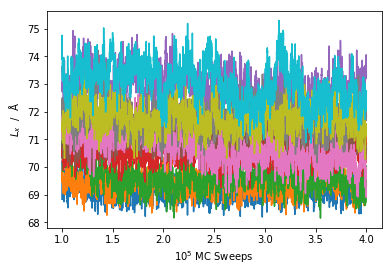

In [118]:
for T in Ts:
    x,y,_ = np.loadtxt('Lx{:d}.dat'.format(T),unpack=True,skiprows=Neq)
    plt.plot(x/1e5,y)
plt.ylabel('$L_x$  /  Å')
plt.xlabel('10$^5$ MC Sweeps')

### Area per Lipid vs Temperature
Set the appropriate $N_{eq}$ and calculate the average and the standard deviation of the area per lipid at equilibrium for each temperature. Plot $\langle a \rangle$ vs $T$.

In [90]:
Neq = 1000

In [167]:
a = np.empty(0)
ae = np.empty(0)
for T in Ts:
    x,y,_ = np.loadtxt('Lx{:d}.dat'.format(T),unpack=True,skiprows=Neq)
    a = np.append(a, (y**2/150*2).mean() )
    ae = np.append(ae, (y**2/150*2).std() )
plt.errorbar(Ts[:],a,ae,lw=0, marker='o', ms=10, elinewidth=2, 
             capsize=2, capthick=1.5,label='{:d}'.format(T) )
plt.ylabel(r'$\langle a \rangle$  /  Å$^2$')
plt.xlabel('$T$  /  K')

StopIteration: 

### Thermal Expansivity
- Calculate the slope of the average area per lipid $\langle a \rangle$ vs temperature for the fluid phase.<br> Hint: use `np.polyfit(x, y, deg, w=None, cov=True)` with `x` being the range of temperatures where we observe a fluid phase, `y` the corresponding $\langle a \rangle$ values and `w` (weights) the inverse of the the corresponding standard deviations of $a$. The `degree` of the fitting polynomial should be set to 1 for a linear regression. With `cov=True`, this method returns the covariance matrix of the polynomial coefficient estimates. The square root of the diagonal of this matrix are the standard deviation estimates for each coefficient.<br>
- Use the slope to estimate the thermal expansivity at 298 K according to the definition,
$$
\alpha_T = \frac{1}{\langle a \rangle}\frac{\partial \langle a \rangle}{\partial T}.
$$
- Can we reproduce the value reported by Cooke and Deserno?

Thermal expansivity: 0.002198006500113652 +/- 6.461163186589611e-05 1/K at 268 K


Text(0.5,0,'$T$  /  K')

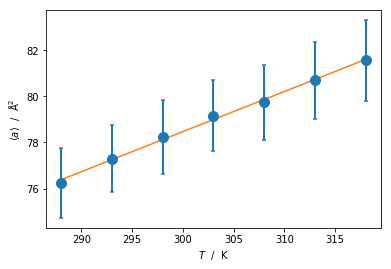

In [158]:
a = np.empty(0)
ae = np.empty(0)
for T in Ts:
    x,y,_ = np.loadtxt('Lx{:d}.dat'.format(T),unpack=True,skiprows=Neq)
    a = np.append(a, (y**2/150*2).mean() )
    ae = np.append(ae, (y**2/150*2).std() )
plt.errorbar(Ts,a,ae,lw=0, marker='o', ms=10, elinewidth=2, 
             capsize=2, capthick=1.5,label='{:d}'.format(T) )

### START CODE HERE ###
p,V = np.polyfit(Ts[7:], a[7:], 1, w=1/ae[7:], cov=True)
x = np.arange(Ts[7:].min(),Ts[7:].max()+1,1)
plt.plot(x,p[0]*x+p[1])
print('Thermal expansivity:',p[0]/a[9],'+/-',np.sqrt(np.diag(V))[0]/a[9],'1/K at',Ts[9],'K')
### END CODE HERE ###

### Alternative using scipy.curve_fit ###
# func = lambda x,a,b : a*x+b
# popt, pcov = curve_fit(func, Ts[7:], a[7:], p0=[0.2,1], sigma=ae[7:])
# x = np.arange(Ts[:].min(),Ts[:].max()+1,1)
# plt.plot(x,func(x,*popt))
# print('Thermal expansivity:',popt[0]/a[9],'+/-',np.sqrt(np.diag(pcov))[0]/a[9],'1/K at',Ts[9],'K')
########################################

plt.ylabel(r'$\langle a \rangle$  /  Å$^2$')
plt.xlabel('$T$  /  K')